In [1]:
import torchaudio
import torch
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from models.lit_cs_detector import interp_targets, get_padding_masks_from_length, LitCSDetector, ModelConfig
from utils.transforms import AudioTransforms

/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model tinker

In [36]:
config = ModelConfig()
config.backbone = 'wavlm-large'
config.freeze_feature_extractor = True
model = LitCSDetector(model_config=config)

In [37]:
list(model.backbone.encoder.parameters())[-1].shape[0]

1024

: 

In [3]:
path = '/home/gfrost/datasets/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_trn.pkl'
df = pd.read_pickle(path)
df.head()

,audio_fpath,tgts
0,//home/gfrost/datasets/soapies_balanced_corpor...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,//home/gfrost/datasets/soapies_balanced_corpor...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,//home/gfrost/datasets/soapies_balanced_corpor...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,//home/gfrost/datasets/soapies_balanced_corpor...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,//home/gfrost/datasets/soapies_balanced_corpor...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
audio_path = df.iloc[8000]['audio_fpath']
tgts1 = torch.tensor(df.iloc[8000]['tgts'])
waveform1, sample_rate = torchaudio.load(audio_path)

audio_path = df.iloc[8001]['audio_fpath']
tgts2 = torch.tensor(df.iloc[8001]['tgts'])
waveform2, sample_rate = torchaudio.load(audio_path)

waveforms = pad_sequence([waveform1.reshape(-1, 1), waveform2.reshape(-1, 1)], batch_first=True)
ll = torch.tensor([waveform1.size(1), waveform2.size(1)])
targets = pad_sequence([tgts1.reshape(-1, 1), tgts2.reshape(-1, 1,)], padding_value=0, batch_first=True).squeeze()

In [5]:
%time
audio_transforms = AudioTransforms()
kek = waveforms.squeeze().cuda()
x, sr = audio_transforms.forward(kek.cpu())
x = x.cuda()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [41]:
from scipy.io import wavfile
import numpy as np

path = "transformed.wav"
wavfile.write(path, 16000, np.array(x[0].cpu()))

In [42]:
path = "raw.wav"
wavfile.write(path, 16000, np.array(kek[0].cpu()))

In [6]:
padding_masks = get_padding_masks_from_length(waveforms.squeeze(), ll)
x, lengths = model.backbone.extract_features(waveforms.squeeze(), padding_mask=padding_masks, ret_lengths=True)
y = interp_targets(targets, torch.max(lengths))

In [88]:
class MixUp():
        def __init__(self, mixup_prob=0.25, mixup_size=0.2, beta=0.3):
            self.mixup_size = mixup_size
            self.mixup_prob = mixup_prob
            self.beta_percentage = beta

        def forward(self, x, lengths, y):
            
            time_param = int(lengths.min()*self.mixup_size)
            self.beta = (torch.rand(1) * self.beta_percentage).to(x.device)
            axis=1

            shape = x.size()
            value = torch.rand(1) * time_param
            min_value = torch.rand(1) * (time_param - value)

            mask_start = (min_value.long()).squeeze()
            mask_end = (min_value.long() + value.long()).squeeze()
            mask = torch.arange(0, x.shape[axis], device=x.device, dtype=x.dtype)
            mask = (mask >= mask_start) & (mask < mask_end)

            assert mask_end - mask_start < time_param

            x, y, index = self.mixup(x, y, mask)

            return x, y, index

        def mixup(self, x, y, mask):

            samples_to_apply_mixup = (torch.rand(x.size(0)) < self.mixup_prob).to(x.device)

            if samples_to_apply_mixup.any() != True: return x, y, index

            x_rolled = x.roll(1, 0)
            y_rolled = y.roll(1, 0)
            y_rolled = y_rolled.float()
            y = y.float()
            broadcast_indexs = samples_to_apply_mixup.unsqueeze(dim=-1).repeat(1, mask.size(0))
            broadcast_masks = mask.repeat(samples_to_apply_mixup.size(0), 1)
            index = torch.logical_and(broadcast_indexs, broadcast_masks)

            x[index] = (1-self.beta)*x[index] + self.beta*x_rolled[index]
            y[index] = (1-self.beta)*y[index] + self.beta*y_rolled[index]

            return x, y, index

In [89]:
mix_up = MixUp(mixup_prob=1, mixup_size=1, beta=1)

In [103]:
kek = torch.zeros_like(x)
kek[1] = 1
kek_mix, kek_y, index = mix_up.forward(kek, torch.tensor([97, 97]), F.one_hot(y.to(torch.long), num_classes=3).float())
# x_mix, y, index = mix_up.forward(x, lengths, F.one_hot(y.to(torch.long), num_classes=3).float())

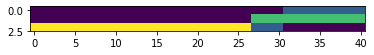

In [104]:
plt.imshow(kek_y[0][index[1]].T)

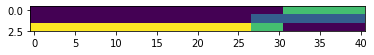

In [105]:
plt.imshow(kek_y[1][index[1]].T)

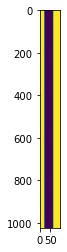

In [107]:
plt.imshow(kek_mix[1].T)

### Soft loss

In [ ]:
def cat_neighbors_for_soft_units(x, soft_units_context):

    x_l = torch.zeros_like(x).repeat(1, 1, soft_units_context)
    x_r = torch.zeros_like(x).repeat(1, 1, soft_units_context)

    for i in range(soft_units_context): x_l[:, i+1:, i*x.size(-1):(i+1)*x.size(-1)] = x[:, :-(i+1), :]
    for i in range(soft_units_context): x_r[:, :-(i+1), i*x.size(-1):(i+1)*x.size(-1)] = x[:, i+1:, :]

    return torch.cat([x, x_l, x_r], dim=-1)

In [ ]:
x = torch.ones(1,100,8) - 2
x[:, 1::2, :] = 1
x[:, 1::3, :] = 0
x = cat_neighbors_for_soft_units(x, 2)

In [ ]:
print(x.shape)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.imshow(x[0].T)

### Cross Entropy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

targets = torch.zeros((8, 50))
targets = torch.cat((targets, 2*torch.ones((8, 50))), dim=-1)
targets = torch.cat((targets, torch.ones((8, 50))), dim=-1)
targets = torch.cat((targets, torch.zeros((8, 50))), dim=-1)
targets = torch.cat((targets, torch.zeros((1, 200))), dim=0)
lengths = torch.tensor([100]*8 + [150])
y_hat = torch.rand((9, 100, 3))

In [ ]:
def powspace(start, stop, power, num):
    start = torch.pow(torch.tensor(start), 1/float(power))
    stop = torch.pow(torch.tensor(stop), 1/float(power))
    return torch.pow( torch.linspace(start, stop, num), power)

def fuzzy_cs_labels(targets, lengths, num_classes, buffer_length=5, buffer_lower_bound=0.5, ord=1):

    assert buffer_lower_bound >= 0.5, "buffer_lower_bound cannot be less than 0.5"

    grad = torch.gradient(targets, dim=-1)[0]
    switches = torch.where(grad!=0)

    l_s = targets[switches[0][1::2], switches[1][0::2]].long()
    r_s = targets[switches[0][1::2], switches[1][1::2]].long()

    l_index = switches[1][0::2]
    r_index = switches[1][1::2]
    b_index = switches[0][1::2]

    if ord == 1: inter_probs_ =  torch.linspace(buffer_lower_bound, 1, buffer_length)
    else: inter_probs_ = torch.tensor([buffer_lower_bound]*buffer_length) + powspace(0, 1-buffer_lower_bound, power=ord, num=buffer_length)
    
    inter_probs_ = torch.stack([inter_probs_, 1-inter_probs_], dim=-1)
    inter_probs = torch.cat([torch.flip(inter_probs_, dims=[0, 1]), inter_probs_], dim=0)

    half_way = len(inter_probs)//2 + 1
    switch_from_pad = r_index+half_way+1 <= lengths[b_index]
    b_index = b_index[switch_from_pad]
    l_index = l_index[switch_from_pad]
    l_s = l_s[switch_from_pad]
    r_s = r_s[switch_from_pad]
    one_hot_labels = F.one_hot(targets.to(torch.long), num_classes=num_classes).float()
    if len(b_index):
        for i, prob in enumerate(inter_probs):

            idex = torch.tensor(len(inter_probs)-i)
            assert(b_index.max() <= lengths.size(0)), f'{b_index.max()} > bs {lengths.size(0)}'
            assert((l_index+half_way-idex).max() < one_hot_labels.size(-2)), f'{(l_index+half_way-idex).max()} > max seq len'

            one_hot_labels[b_index, l_index+half_way-idex, l_s] = prob[1]
            one_hot_labels[b_index, l_index+half_way-idex, r_s] = prob[0]
            
    del r_s, l_s, l_index, r_index, inter_probs

    return one_hot_labels.float(), grad

In [ ]:
fuzzy_one_hots_exp, grad = fuzzy_cs_labels(targets, lengths, 3, buffer_length=7, buffer_lower_bound=0.7, ord=0.5)
fuzzy_one_hots_lin, grad = fuzzy_cs_labels(targets, lengths, 3, buffer_length=7, buffer_lower_bound=0.7)

In [ ]:
plt.plot(fuzzy_one_hots_lin[0, 10:80, 0])
plt.plot(fuzzy_one_hots_lin[0, 10:80, 2])
plt.plot(fuzzy_one_hots_exp[0, 10:80, 0])
plt.plot(fuzzy_one_hots_exp[0, 10:80, 2])

In [ ]:
def interp_targets(targets, max_length):
    targets_ = targets.reshape(targets.size(0), 1, 1, targets.size(1)).to(torch.float32)
    interp_legnths = (1, max_length)
    ds_targets = F.interpolate(targets_, interp_legnths).squeeze()
    return ds_targets.to(torch.long)

In [ ]:
class label_smooth_loss(torch.nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(label_smooth_loss, self).__init__()
        eps = smoothing / num_classes
        self.negative = eps
        self.positive = (1 - smoothing) + eps
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.negative)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.positive)
        return torch.sum(-true_dist * pred, dim=1).mean(), true_dist

loss_func = label_smooth_loss(3)

In [ ]:
# Based off Deep Learning, Goodfellow et al definition
class CustomLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        """Custom cross entropy with label smoothing, which allows
        for label smoothing to be applied to a ground truth distribution
        IMPORTANT: Does not get same loss as torch w/ one-hot labels """
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        if len(target.size()) < 2: F.one_hot(target)
        n = target.size(-1)

        max_probs, idxs = torch.max(target, dim=-1)
        
        residuals = max_probs * self.epsilon
        norm_residuals = residuals / (n - 1)

        target[range(len(idxs)), idxs] = target[range(len(idxs)), idxs] - residuals
        target = target + norm_residuals.unsqueeze(dim=-1).repeat(1, n)
        target[range(len(idxs)), idxs] = target[range(len(idxs)), idxs] - norm_residuals

        return F.cross_entropy(preds, target)



In [ ]:
fake_preds = torch.randn_like(fuzzy_one_hots_lin[0])

In [ ]:
smoothing = 0.1
custom_loss_func = CustomLabelSmoothingCrossEntropy(epsilon=smoothing)
custom_label_smooth = custom_loss_func(fake_preds, fuzzy_one_hots_lin[0].detach().clone())
torch_label_smooth = F.cross_entropy(fake_preds, fuzzy_one_hots_lin[0].detach().clone(), label_smoothing=smoothing)

print(f'torch smoothing: {torch_label_smooth}')
print(f'custom smoothing: {custom_label_smooth}')

### CTC

In [ ]:
ds_factor = 335

In [ ]:
# Hacky way to use torch's vision interpolation stuff

alpha = 0.49 # Shrink factor to get ctc to work

tgts = torch.tensor(tgts1, dtype=torch.float32).reshape(1, 1, 1, -1)
ds_size1 = int(tgts.size(-1)/ds_factor*alpha)
interp_legnths1 = (1,  ds_size1)
interp_tgts1 = F.interpolate(tgts, interp_legnths1).squeeze()

tgts = torch.tensor(tgts2, dtype=torch.float32).reshape(1, 1, 1, -1)
ds_size2 = int(tgts.size(-1)/ds_factor*alpha)
interp_legnths2 = (1,  ds_size2)
interp_tgts2 = F.interpolate(tgts, interp_legnths2).squeeze()

target = pad_sequence([interp_tgts1.reshape(-1, 1), interp_tgts2.reshape(-1, 1)], batch_first=True, padding_value=1).squeeze()
target_lengths = torch.stack([torch.tensor(ds_size1), torch.tensor(ds_size2)])

In [ ]:
target = target.to(torch.long)
input = F.log_softmax(y_hat, dim=-1)
N, T, C = input.shape
input = input.view(((T, N, C)))

In [ ]:
#loss = ctc_loss(input, target, input_lengths, target_lengths)
ctc_loss = torch.nn.CTCLoss(blank=0, zero_infinity=True)
ctc_loss(input, target, lengths, target_lengths)

In [ ]:
T = 48
C = 3
N = 2

S = 30
S_min = 29

input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)

ctc_loss = torch.nn.CTCLoss(blank=0, zero_infinity=False)

print(loss)

### Train

In [ ]:
import sys
sys.path.append('..')
import torch
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, DeviceStatsMonitor
from finetuning_scheduler import FinetuningScheduler
from utils.datasets import CSDataset, collator
from torch.utils.data import DataLoader
from models.lit_cs_detector import LitCSDetector, ModelConfig

root_path = '/home/gfrost/datasets'

path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_trn.pkl'
df_trn = pd.read_pickle(path)
path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_dev.pkl'
df_dev = pd.read_pickle(path)
path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_tst.pkl'
df_tst = pd.read_pickle(path)

In [ ]:
def norm_labels(x):
    x[x > 0] = 1.0
    return x

df_trn.tgts.map(norm_labels)

In [ ]:
df_trn.tgts

In [ ]:
BS_SIZE = 8
df_trn.tgts = df_trn.tgts-1
df_dev.tgts = df_dev.tgts-1
dataset_trn = CSDataset(df_trn)
dataset_dev = CSDataset(df_dev)

train_dataloader = DataLoader(dataset_trn, batch_size=BS_SIZE, shuffle=True, collate_fn=collator, num_workers=12)
dev_dataloader = DataLoader(dataset_dev, batch_size=BS_SIZE, collate_fn=collator, num_workers=12)

In [ ]:
config = ModelConfig()
config.backbone = 'xlsr'
config.specaugment=True
config.feature_masking_percentage=0.02
config.time_masking_percentage=0.02
config.label_smoothing=0.1
config.freeze_feature_extractor=True

model = LitCSDetector(config=config)

In [ ]:
from utils.lit_callbacks import BackboneFinetuning

# Callbacks
learning_rate_callback = LearningRateMonitor(logging_interval='step') 
checkpoint_callback = ModelCheckpoint(monitor='val/val_acc',
                                        filename='{epoch}-{val/val_loss:.2f}-{val/val_auc:.2f}',
                                        save_on_train_epoch_end=False,
                                        auto_insert_metric_name=False,
                                        save_last=True,
                                        mode='max'
                                        )
unfreeze_at_epoch = 1                              
backbone_finetuning_callback = BackboneFinetuning(unfreeze_at_epoch, lambda epoch: 2)
device_stats_callback = DeviceStatsMonitor()

callbacks = [learning_rate_callback, checkpoint_callback, device_stats_callback]

# Logger                               
tb_logger = pl_loggers.TensorBoardLogger(save_dir="../logs/")
trainer = pl.Trainer(logger=tb_logger, callbacks=callbacks, max_epochs=16, gpus=1, gradient_clip_val=0.5, accumulate_grad_batches=8, log_every_n_steps=100, precision=32)

model.hparams.learning_rate = 5e-5
trainer.fit(model, train_dataloader, dev_dataloader)

In [ ]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader, dev_dataloader)
fig = lr_finder.plot(suggest=True)
fig.show()

### WavLM tinker

In [ ]:
import sys
sys.path.append('..')

from models.WavLM import WavLM, WavLMConfig
import torch
import torch.nn.functional as F
from models.lit_cs_detector import get_padding_masks_from_length

# load the pre-trained checkpoints
checkpoint = torch.load('/home/gfrost/projects/penguin/models/WavLM-Large.pt')
cfg = WavLMConfig(checkpoint['cfg'])
model = WavLM(cfg)
model.load_state_dict(checkpoint['model'])

model.eval()

# extract the representation of last layer
wav_input_16khz = torch.randn(2,10000)
pad = torch.zeros(2, 5000)
wav_input_16khz = torch.cat([wav_input_16khz, pad], dim=-1)
lengths = torch.tensor([10000, 10000])
padding_masks = get_padding_masks_from_length(wav_input_16khz, lengths)

rep, lengths = model.extract_features(wav_input_16khz, output_layer=model.cfg.encoder_layers, padding_mask=padding_masks, ret_lengths=True)

In [ ]:
masks = torch.zeros_like(wav_input_16khz)
for i, length in enumerate(lengths): masks[i, length:] = 1

In [ ]:
fake_input = torch.arange(100).unsqueeze(dim=0).repeat(lengths.size(0), 1)
lengths = torch.tensor([50, 25]).unsqueeze(dim=-1).repeat(1, fake_input.size(-1))
masks = fake_input > lengths

In [ ]:
import torch
import torch.nn.functional as F
from WavLM import WavLM, WavLMConfig

torch.autograd.set_detect_anomaly(True)

checkpoint = torch.load('/home/gfrost/projects/penguin/models/WavLM-Large.pt')
cfg = WavLMConfig(checkpoint['cfg'])

model = WavLM(cfg)
model.load_state_dict(checkpoint['model'])
model.train()

wav_input_16khz = torch.randn(2,10000)
y_hat, _ = model.extract_features(wav_input_16khz)

loss = F.cross_entropy(y_hat.view(-1, 1024), torch.ones((y_hat.view(-1, 1024).size(0)), dtype=torch.long))
loss.backward()

### Metrics

Evaluate select models during development

In [1]:
import sys
sys.path.append('..')

import torchmetrics.functional as FM
import torch.nn.functional as F
import torch
from models.lit_cs_detector import LitCSDetector, get_unpadded_idxs
from models.lit_blstm_e2e import LitBLSTME2E
from utils.transforms import interp_targets
from utils.datasets import load_dfs, create_dataloaders
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_dir="/home/gfrost/datasets"
supported_cs_pairs = ["engzul", "engxho", "engtsn", "engsot"]

dfs_dev = []
dfs_trn = []

for cs_pair in supported_cs_pairs:
    
    data_df_root_dir = os.path.join(data_dir, \
        f"soapies_balanced_corpora/cs_{cs_pair}_balanced/lang_targs_mult/")
    
    df_trn, df_dev = load_dfs(data_df_root_dir, cs_pair, all_cs_pairs=True, lang_fams=False)
    
    dfs_dev.append(df_dev)
    dfs_trn.append(df_trn)

df_dev = pd.concat(dfs_dev)
df_trn = pd.concat(dfs_trn)

train_dataloader, dev_dataloader = create_dataloaders(df_trn, df_dev, melspecs=True, bs=8, num_workers=4)

In [42]:
from dataclasses import dataclass
import torch.nn.utils.rnn as rnn_util

@dataclass
class ModelConfig():
    n_classes:int=5
model_config = ModelConfig()

device = 'cuda:1'
model_path = "/home/gfrost/projects/penguin/logs/lightning_logs/version_116/checkpoints/43-0.00-0.00.ckpt"
ckpt = torch.load(model_path)['state_dict']

model = LitBLSTME2E(model_config).to(device)
model.load_state_dict(ckpt)

model.eval()

preds = []
lengths = []
wavs = []
labels = []
with torch.no_grad():
    for batch in tqdm(dev_dataloader):
        x, x_l, y, _ = batch
        x = x.to(device)
        x_l = x_l.to(device)
        # y_hat, embeddings, _lengths, _ = model.forward(x, x_l)
        y = interp_targets(y, x.size(1))
        y = rnn_util.pack_padded_sequence(y, x_l.cpu(), batch_first=True, enforce_sorted=False).data.to(x.device)
        x = rnn_util.pack_padded_sequence(x, x_l.cpu(), batch_first=True, enforce_sorted=False)
        
        y_hat, embeddings = model.forward(x)
        # y = interp_targets(y, torch.max(_lengths))
        
        preds.append(y_hat.detach().cpu())
        labels.append(y.detach().cpu())
        # lengths.append(_lengths.detach().cpu())
        lengths.append(x_l.detach().cpu())
        # wavs.append(x.detach().cpu())

100%|██████████| 222/222 [00:01<00:00, 178.20it/s]


In [ ]:
unbatched_preds = []
unbatched_labels = []
unbatched_wavs = []
unbatched_lengths = []

for i, pred_batch in enumerate(preds):
    print(pred_batch.shape)
    for j, pred in enumerate(pred_batch):
        print(pred.shape)        
        unbatched_preds.append(F.softmax(pred[:int(lengths[i][j])], dim=-1))
        if len(labels[i].size()) > 1:
            unbatched_labels.append(labels[i][j][:int(lengths[i][j])])
        else: 
            unbatched_labels.append(labels[i][:int(lengths[i][j])])
        unbatched_lengths.append(int(lengths[i][j]))
        unbatched_wavs.append(wavs[i][j])

In [6]:
print(torch.bincount(torch.cat(unbatched_labels)))

tensor([55821, 11906, 25854, 25808, 25648])


In [7]:
accuracy = (torch.softmax(torch.cat(unbatched_preds), dim=-1).argmax(dim=-1) == torch.cat(unbatched_labels)).sum().float() /float(torch.cat(unbatched_labels).size(0))
pred_all_zero = (torch.zeros_like(torch.cat(unbatched_preds).argmax(dim=-1)) == torch.cat(unbatched_labels)).sum().float()/float(torch.cat(unbatched_labels).size(0))

<Figure size 432x288 with 0 Axes>

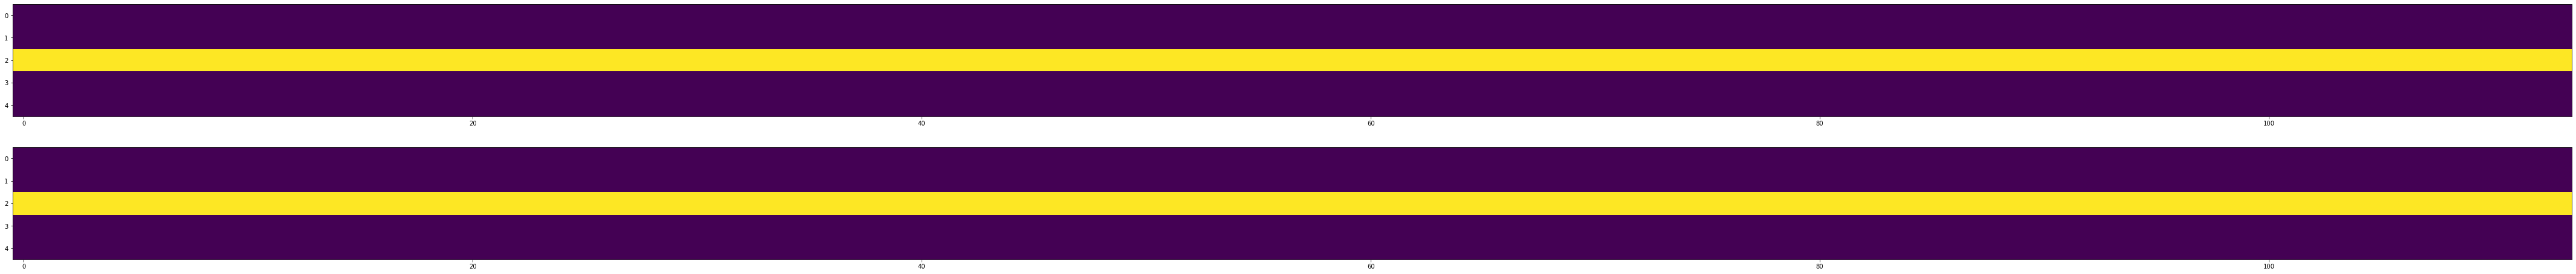

In [8]:
# Some dev utts don't have cs
index = 500

plt.tight_layout()
fig, axs = plt.subplots(2, 1, figsize=(len(unbatched_preds[index])*(16 / 24), 8))
axs[0].imshow(F.one_hot(unbatched_preds[index].argmax(-1), num_classes=5).T)
axs[1].imshow(F.one_hot(unbatched_labels[index], num_classes=5).T)

In [9]:
per_utt_acc = [(preds.argmax(dim=-1).float()==unbatched_labels[i].float()).sum().float()/float(unbatched_labels[i].size(0)) for i, preds in enumerate(unbatched_preds)]
# auc = FM.auroc(torch.cat(unbatched_preds)[:,1], torch.cat(unbatched_labels))
# fpr, tpr, thresh = FM.roc(torch.cat(unbatched_preds)[:,1], torch.cat(unbatched_labels))

In [10]:
per_utt_acc = np.array(per_utt_acc)

idxs = np.argsort(per_utt_acc)
per_utt_acc_sorted = per_utt_acc[idxs]
per_utt_lengths_sorted = np.array(unbatched_lengths)[idxs]
line_75 = int(len(per_utt_acc_sorted)*0.25)

In [11]:
# save some bad wavs
# from scipy.io import wavfile

# for i in range(4):
#     utterance = unbatched_wavs[idxs[i]]
#     wavfile.write(f'bad_ld_utt_{i}.wav', 16000, np.array(utterance))

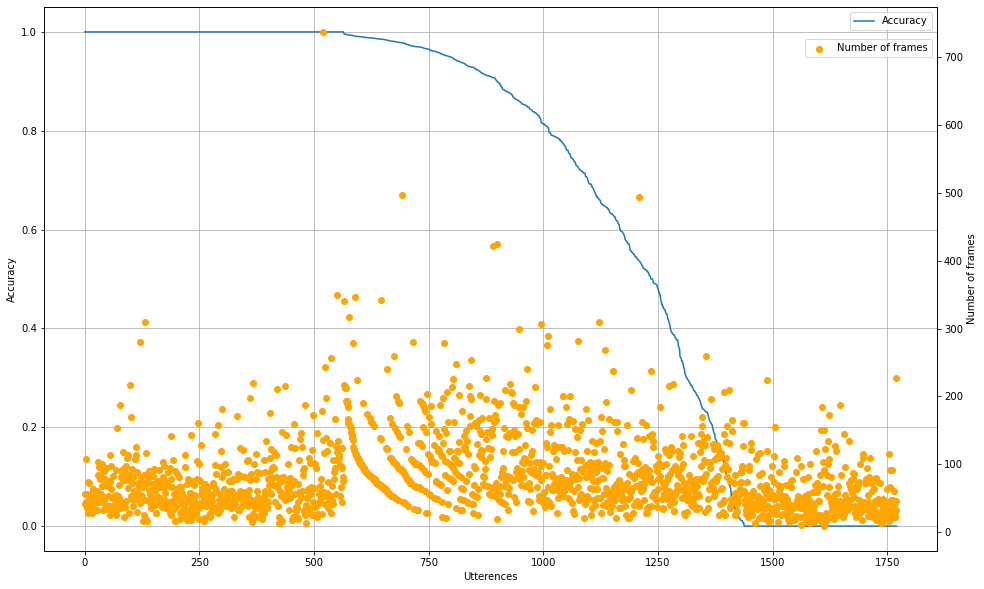

In [13]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax1.plot(np.flip(per_utt_acc_sorted), label="Accuracy")

ax2 = ax1.twinx()
ax2.scatter(np.arange(len(per_utt_lengths_sorted)), np.flip(per_utt_lengths_sorted), label="Number of frames", color='orange')

ax1.legend()
ax2.legend(loc='best', bbox_to_anchor=(1,0.95))
ax2.set_ylabel("Number of frames")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Utterences")
ax1.grid(True)
# plt.savefig('../figs/acc_v_utt_wav2vec2_base_100_trn.jpeg', dpi=500)

In [14]:
clean_unbatched_preds = [unbatched_preds[i] for i in idxs[per_utt_acc_sorted > 0.0]]
clean_unbatched_labels = [unbatched_labels[i] for i in idxs[per_utt_acc_sorted > 0.0]]

num_classes = 5
cm_clean = np.array(FM.confusion_matrix(torch.cat(clean_unbatched_preds).argmax(dim=-1), torch.cat(clean_unbatched_labels), num_classes=num_classes))
cm = np.array(FM.confusion_matrix(torch.cat(unbatched_preds).argmax(dim=-1), torch.cat(unbatched_labels), num_classes=num_classes))

In [15]:
torch.bincount(torch.cat(unbatched_labels))

tensor([55821, 11906, 25854, 25808, 25648])

In [16]:
print(cm_clean[np.diag_indices(cm.shape[0])]/ torch.bincount(torch.cat(clean_unbatched_labels)))
print(cm[np.diag_indices(cm.shape[0])]/ torch.bincount(torch.cat(unbatched_labels)))

print(len(clean_unbatched_preds))
print(len(unbatched_preds))


tensor([0.8735, 0.8748, 0.8301, 0.6366, 0.8139], dtype=torch.float64)
tensor([0.8489, 0.8525, 0.6671, 0.4506, 0.7085], dtype=torch.float64)
1438
1771


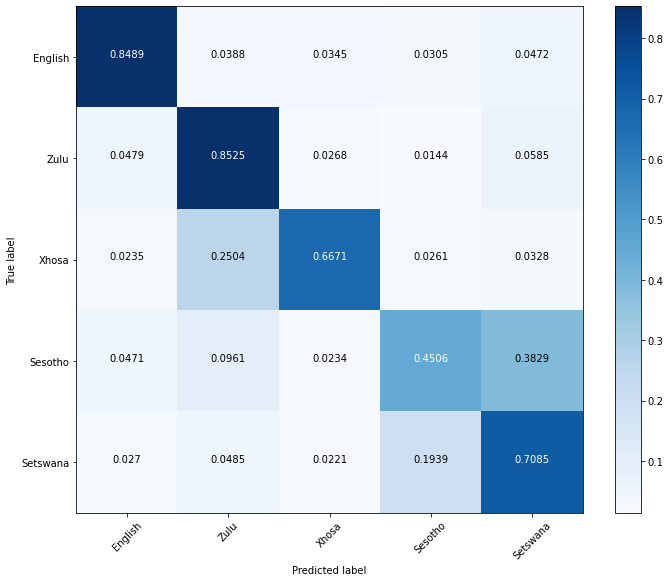

In [20]:
target_names = ["English", "Zulu", "Xhosa", "Sesotho", "Setswana"]
lang_fams = ["English", "Nguni", "Sotho–Tswana"]
plot_cm(cm, target_names, save=True)

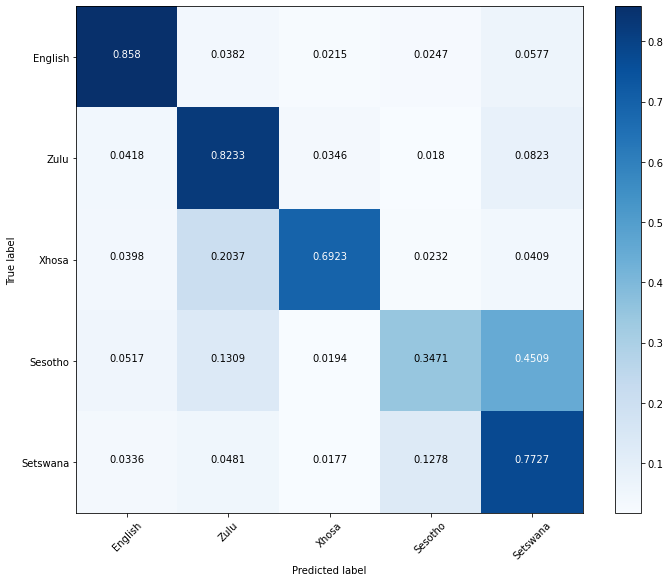

In [16]:
target_names = ["English", "Zulu", "Xhosa", "Sesotho", "Setswana"]
lang_fams = ["English", "Nguni", "Sotho–Tswana"]
plot_cm(cm, target_names, save=True)

In [ ]:
target_names = ["English", "Zulu", "Xhosa", "Sesotho", "Setswana"]
lang_fams = ["English", "Nguni", "Sotho–Tswana"]
plot_cm(cm_clean, lang_fams, save=False)

In [19]:
import itertools

def plot_cm(cm, target_names, norm=True, save=False):
    
    if norm: cm = np.round(cm / np.sum(cm, axis=1)[:, np.newaxis], 4)
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save: plt.savefig("../figs/cm.pdf", dpi=500)
    plt.show()